In [72]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from rasterio.transform import Affine
import pandas as pd
from torchvision.transforms import ToTensor

In [5]:
file_name = 'World_Atlas_2015/World_Atlas_2015.tif'

In [7]:
with rasterio.open(file_name) as image:
    image_array = image.read()
# 2min 10 sec

In [57]:
torch_image = ToTensor()(image_array)
print(torch_image.shape)

torch.Size([43200, 1, 17406])


In [74]:
# imag is defined here!!!
imag = torch_image.permute(1,2,0).numpy()[0]

In [10]:
imag.shape

(17406, 43200)

In [ ]:
def saveImgNpz(imag, filename, lon_min=-180, lon_max=180, lat_min=-90, lat_max=+90):
    # Generate lat/lon values for each point
    latitudes = np.linspace(lat_min, lat_max, imag.shape[0])
    longitudes = np.linspace(lon_min, lon_max, imag.shape[1])

    # Create a grid of coordinates
    lon_grid, lat_grid = np.meshgrid(longitudes, latitudes)

    # Flatten the arrays to create columns
    lat_flat = lat_grid.flatten()
    lon_flat = lon_grid.flatten()
    value_flat = np.ma.filled(imag.flatten(), np.nan)  # Convert masked values to NaN

    # Create a DataFrame from the flattened arrays
    data = {
        'Latitude': lat_flat,
        'Longitude': lon_flat,
        'Value': value_flat
    }

    df = pd.DataFrame(data)

    df_clean = df.dropna()
    df_clean.to_csv(filename, index=False)
    
    structured_array = df_clean.to_records(index=False)
    np.savez_compressed(filename, data=structured_array)


In [76]:
def saveImgToCsv(imag, filename, lon_min=-180, lon_max=180, lat_min=-90, lat_max=+90):
    # Generate lat/lon values for each point
    latitudes = np.linspace(lat_min, lat_max, imag.shape[0])
    longitudes = np.linspace(lon_min, lon_max, imag.shape[1])

    # Create a grid of coordinates
    lon_grid, lat_grid = np.meshgrid(longitudes, latitudes)

    # Flatten the arrays to create columns
    lat_flat = lat_grid.flatten()
    lon_flat = lon_grid.flatten()
    value_flat = np.ma.filled(imag.flatten(), np.nan)  # Convert masked values to NaN

    # Create a DataFrame from the flattened arrays
    data = {
        'Latitude': lat_flat,
        'Longitude': lon_flat,
        'Value': value_flat
    }

    df = pd.DataFrame(data)

    df_clean = df.dropna()
    df_clean.to_csv(filename, index=False)
    # np.savetxt(filename, imag, delimiter=",")

saveImgToCsv(imag, 'World.csv')
# 12 min 1.2GB
# 15 min 1.44GB
# 18 min 1.76GB
# 21 min 2.12GB
# 28 min 2.88GB
# 32 min 3.33GB
# 36 min 3.50GB
# 40 min 3.9GB
# 46 min 4.6GB
# 49 min 5.0GB


KeyboardInterrupt: 

In [ ]:
saveImgToCsv(imag, 'World.csv')
# 12 min 1.2GB
# 

In [ ]:
def toCsvToImag(filename, lon_min=-180, lon_max=180, lat_min=-90, lat_max=+90):
    df = pd.read_csv(filename)
    lon_step = 360 / 43200
    lat_step = 180 / 17406
    latitudes = np.arange(lat_min, lat_max, lat_step)
    longitudes = np.arange(lon_min, lon_max, lon_step)
    imag = np.zeros((len(latitudes), len(longitudes)))
    for i in range(len(df)):
        lat = df['Latitude'][i]
        lon = df['Longitude'][i]
        value = df['Value'][i]
        lat_index = np.where(latitudes == lat)
        lon_index = np.where(longitudes == lon)
        imag[lat_index, lon_index] = value
    return imag
World = toCsvToImag('World.csv')

In [11]:
#plt.imshow(np.log(imag[:17406/2, :17406/2]))

C:\Users\yhjo7\AppData\Local\Temp\ipykernel_6780\4032503161.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(imag))


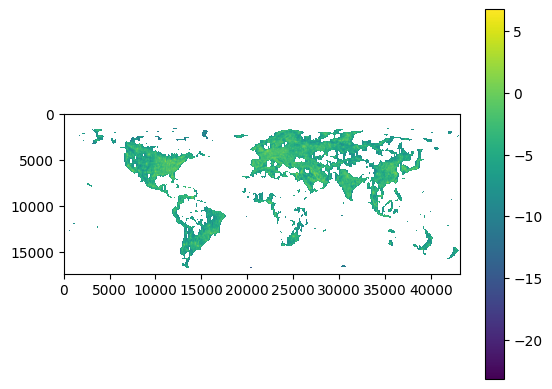

In [18]:
plt.imshow(np.log(imag))
plt.colorbar()
# 1 min

In [58]:
def getTransform(file_name):
    with rasterio.open(file_name) as image:
        # Extract the transformation and use it to compute the geographical coordinates
        transform = image.transform
    return transform
transform = getTransform(file_name)

In [70]:
def get_log_imag(imag, transform, lon_min = -180, lat_min = -90, lon_max = 180, lat_max = 90):
    inv_transform = ~transform
    x_pixels_min, y_pixels_min = inv_transform * (lon_min, lat_max)
    x_pixels_max, y_pixels_max = inv_transform * (lon_max, lat_min)

    # Round and convert to integer
    x_pixels_min, y_pixels_min = int(np.floor(x_pixels_min)), int(np.floor(y_pixels_min))
    x_pixels_max, y_pixels_max = int(np.ceil(x_pixels_max)), int(np.ceil(y_pixels_max))

    # Ensure the slicing indices are within the image bounds
    x_pixels_min, y_pixels_min = max(x_pixels_min, 0), max(y_pixels_min, 0)
    x_pixels_max, y_pixels_max = min(x_pixels_max, imag.shape[1]), min(y_pixels_max, imag.shape[0])

    # Log transformation
    imag_log = np.log(imag[y_pixels_min:y_pixels_max, x_pixels_min:x_pixels_max])
    imag_log = np.ma.masked_invalid(imag_log)
    boundary = np.array([lon_min, lon_max, lat_min, lat_max])
    return imag_log, boundary

World, bWorld = get_log_imag(imag, transform)
Europe, bEurope = get_log_imag(imag, transform, -25, 35, 45, 70)
Africa, bAfrica = get_log_imag(imag, transform, -25, -35, 45, 35)
South_America, bSouth_America = get_log_imag(imag, transform, -90, -60, -30, 15)
North_America, bNorth_America = get_log_imag(imag, transform, -180, 15, -30, 90)
Australia, bAustralia = get_log_imag(imag, transform, 110, -45, 160, -10)
Asia, bAsia = get_log_imag(imag, transform, 40, 0, 180, 70)
    

x_pixels_max: 27001, x_pixels_min: 18600, y_pixels_max: 6007, y_pixels_min: 1806


C:\Users\yhjo7\AppData\Local\Temp\ipykernel_6780\381509973.py:38: RuntimeWarning: divide by zero encountered in log
  imag_log = np.log(imag[y_pixels_min:y_pixels_max, x_pixels_min:x_pixels_max])


In [16]:
# # Open the image to access its metadata
# with rasterio.open(file_name) as image:
#     # Extract the transformation and use it to compute the geographical coordinates
#     transform = image.transform
#     # Define the pixel range you are interested in
#     x_pixels_min, y_pixels_min = 0, 0  # Start corner
#     x_pixels_max, y_pixels_max = imag.shape[1], imag.shape[0]  # End corner
    
#     # Convert pixel coordinates to geographical coordinates
#     lon_min, lat_max = transform * (x_pixels_min, y_pixels_min)
#     lon_max, lat_min = transform * (x_pixels_max, y_pixels_max)


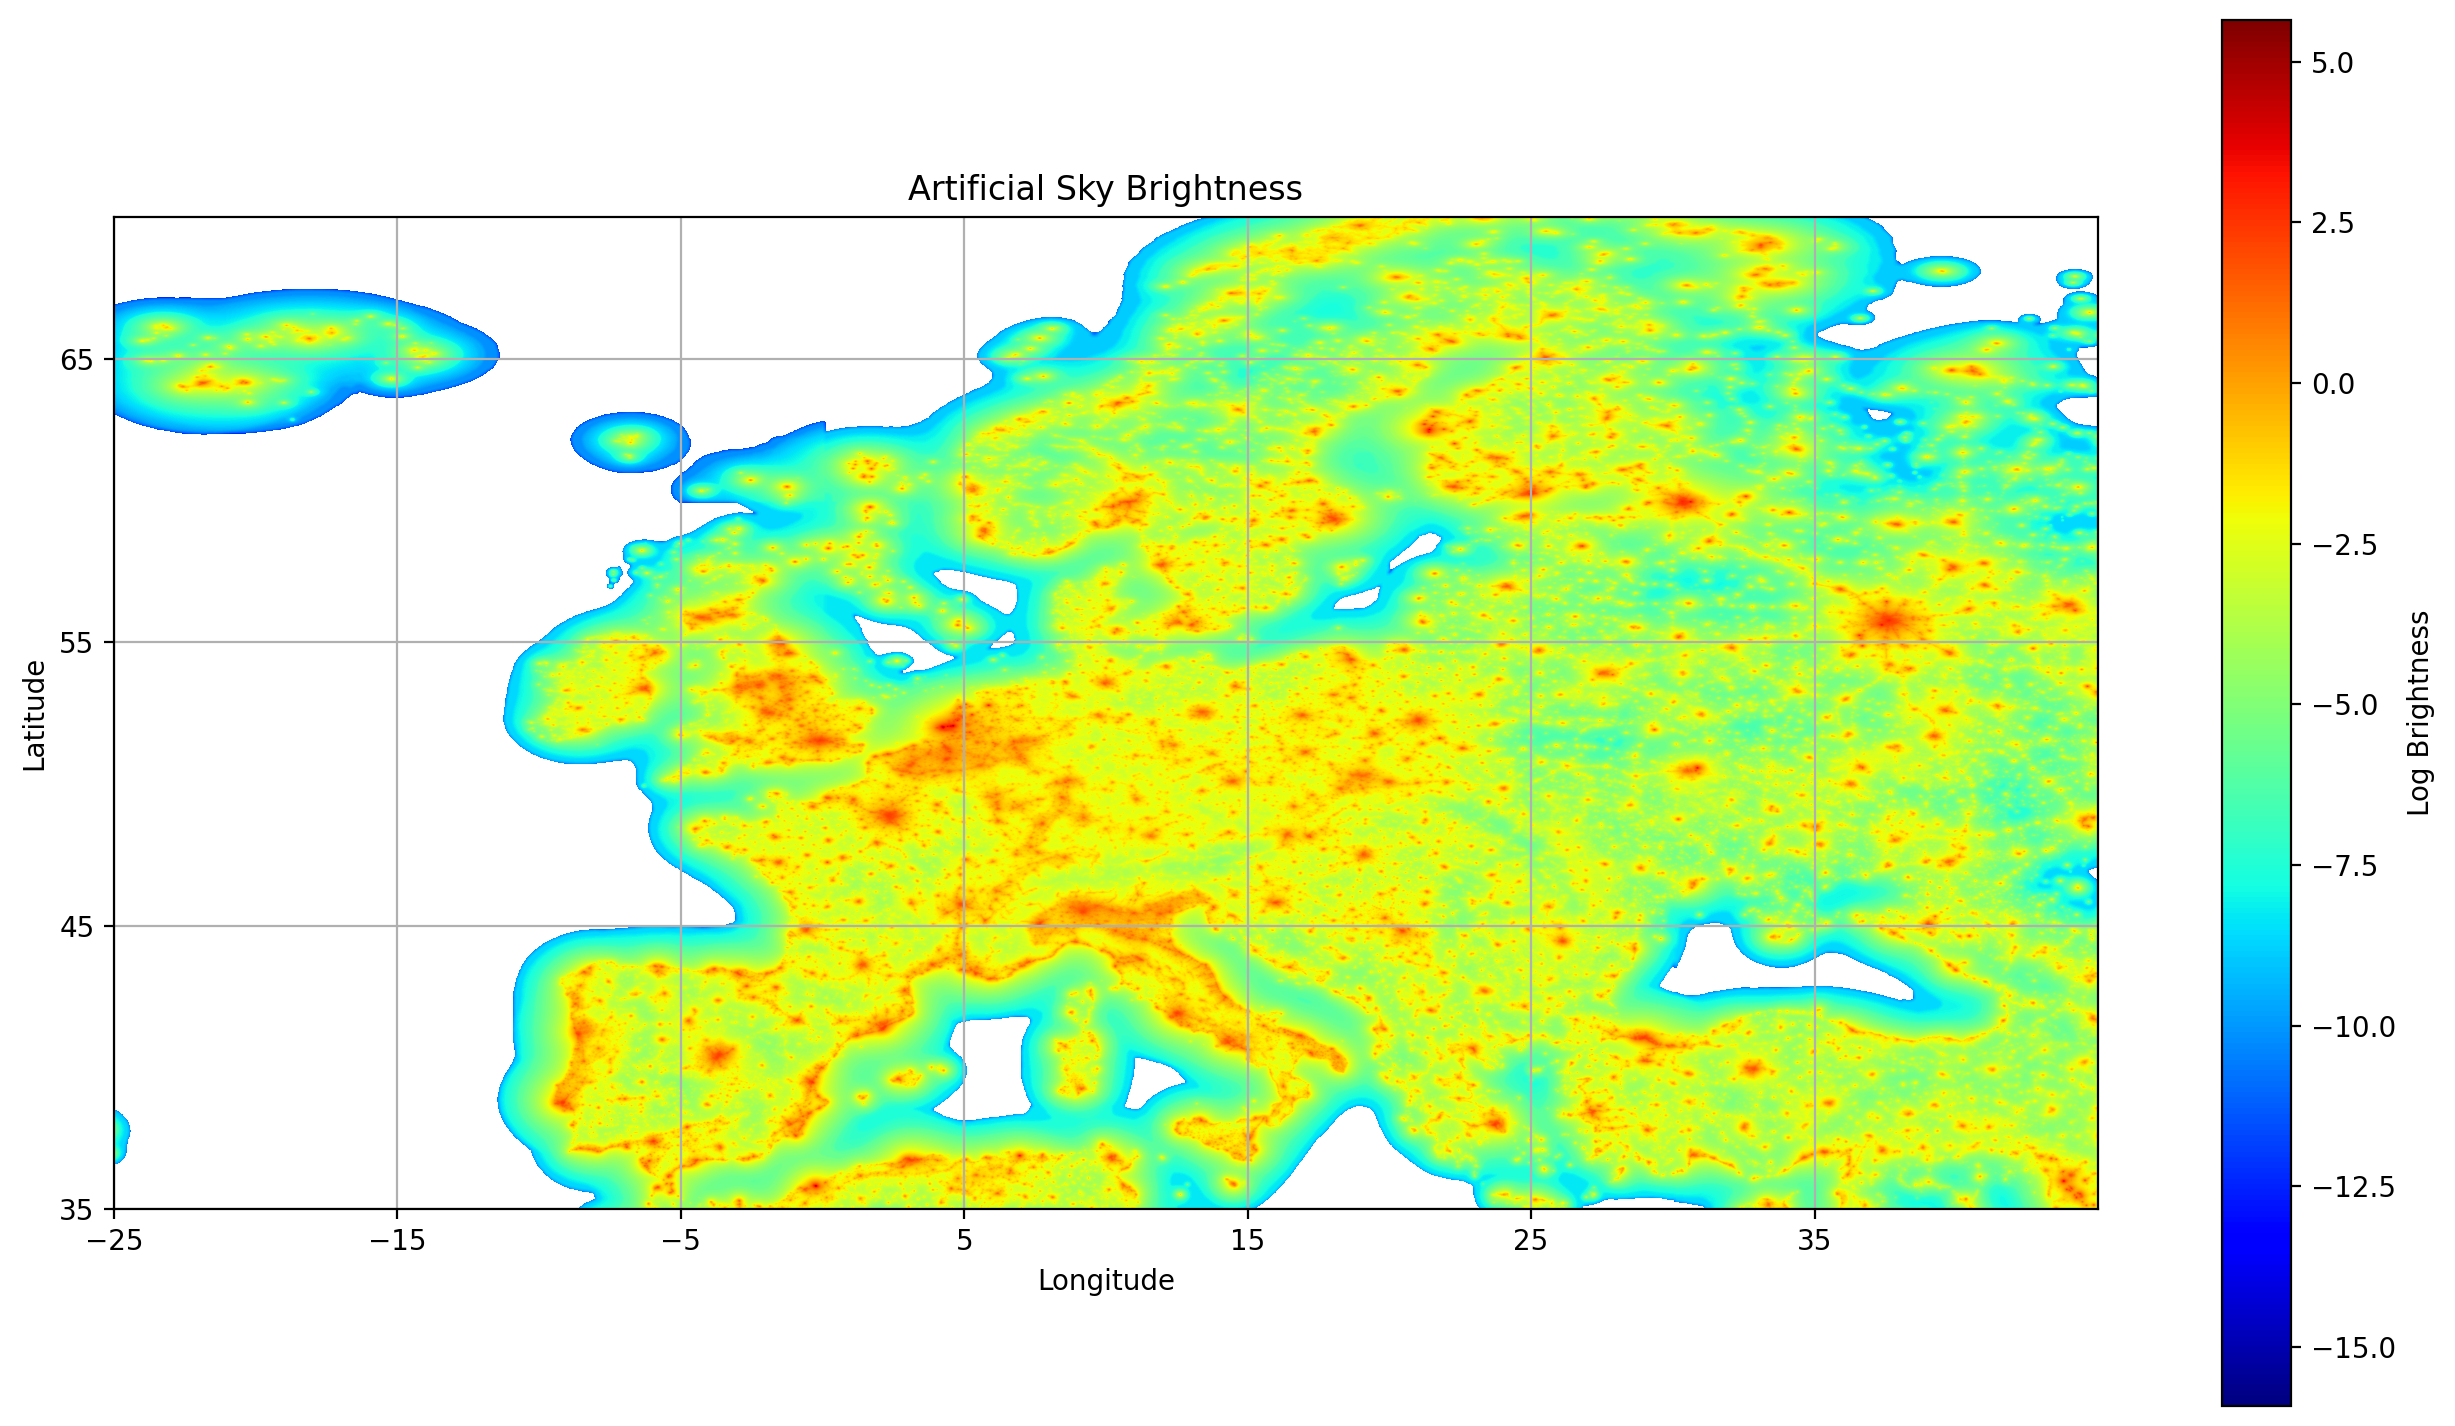

In [71]:
def plotlogimag(imag_log, boundary, title):
    lon_min = boundary[0]
    lon_max = boundary[1]
    lat_min = boundary[2]
    lat_max = boundary[3]

    # Plot the data with geographic coordinates
    fig, ax = plt.subplots(figsize=(20, 11), dpi = 200)
    cax = ax.imshow(imag_log, extent=[lon_min, lon_max, lat_min, lat_max], origin='upper', cmap = 'jet')

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Artificial Sky Brightness of {title}')
    ax.set_xticks(np.arange(lon_min, lon_max, 10))
    ax.set_yticks(np.arange(lat_min, lat_max, 10))
    ax.grid()
    fig.colorbar(cax, ax=ax, label='Log Brightness')
plotlogimag(World, bWorld, 'the World')
plotlogimag(Europe, bEurope, 'Europe')
plotlogimag(Africa, bAfrica, 'Africa')
plotlogimag(South_America, bSouth_America, 'South America')
plotlogimag(North_America, bNorth_America, 'North America')
plotlogimag(Australia, bAustralia, 'Australia')
plotlogimag(Asia, bAsia, 'Asia')

# 

C:\Users\yhjo7\AppData\Local\Temp\ipykernel_6780\3110863501.py:6: RuntimeWarning: divide by zero encountered in log
  imag_log = np.log(imag[0:y_pixels_max, 0:x_pixels_max])


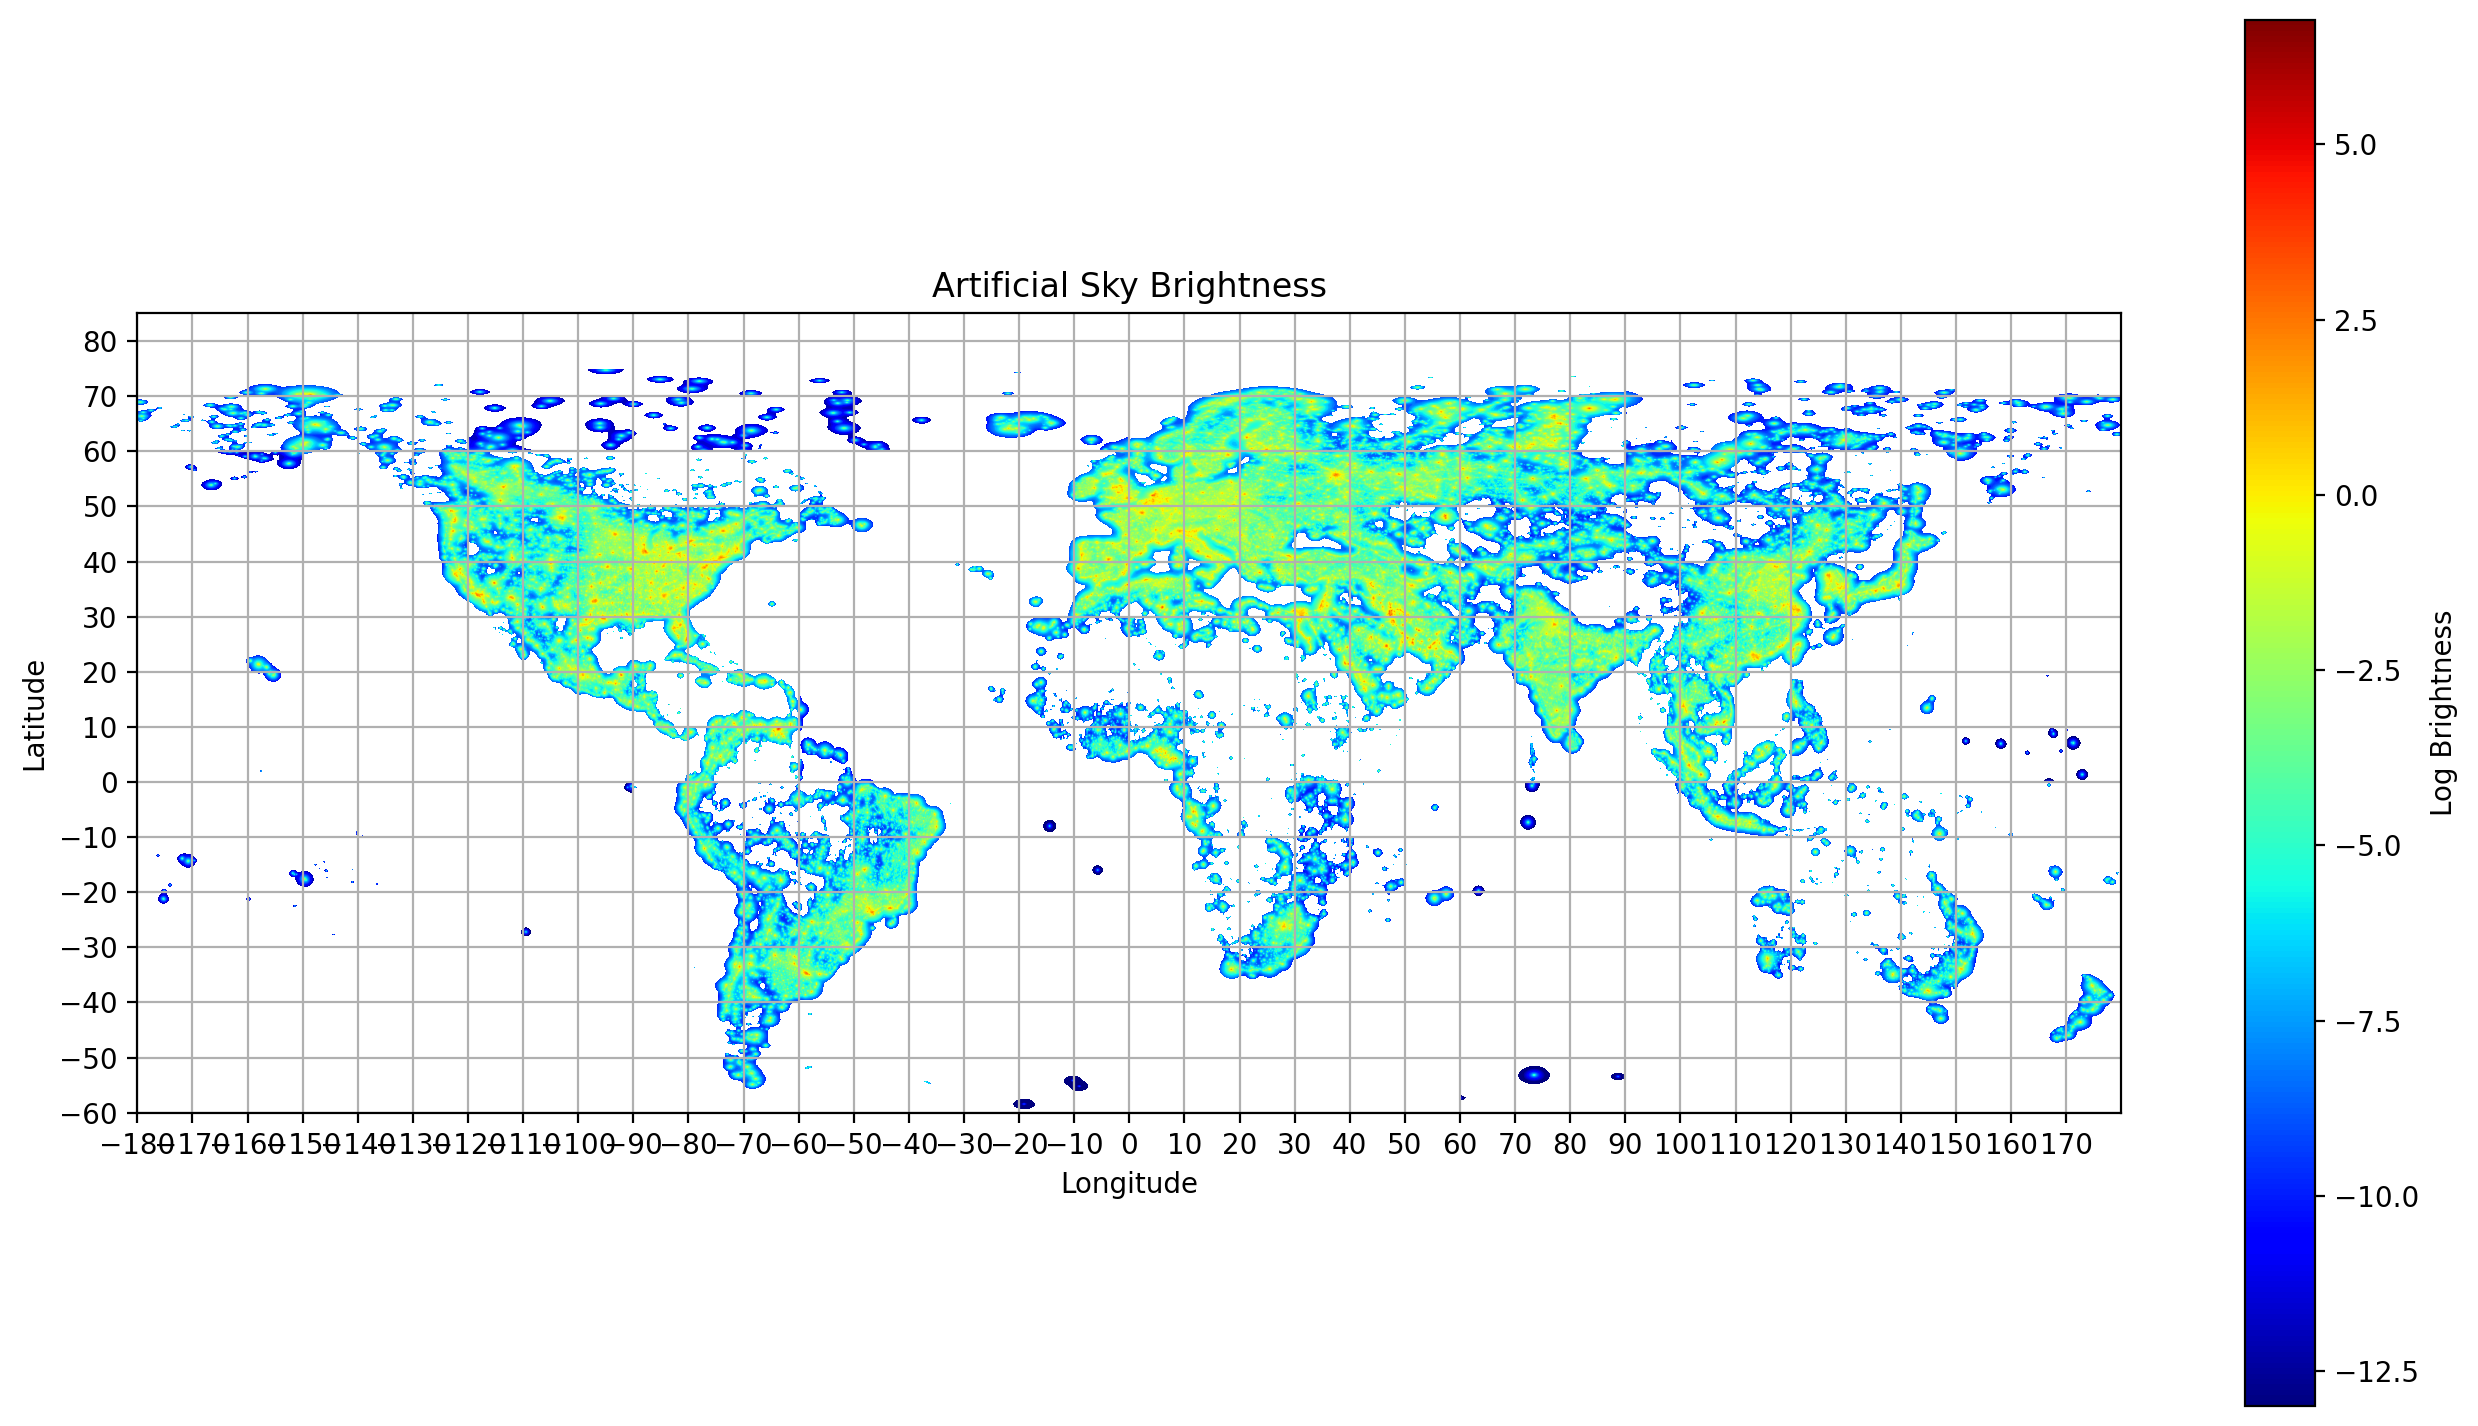

In [33]:
# Ensure imag is prepared as before, focusing on the subset of interest
# This assumes 'imag' has been defined as shown previously
# If imag is not defined here, ensure it is computed before this code

# Log transformation and masking of zeros to avoid log(0)
imag_log = np.log(imag[0:y_pixels_max, 0:x_pixels_max])
imag_log = np.ma.masked_invalid(imag_log)  # Mask invalid values

# Plot the data with geographic coordinates
fig, ax = plt.subplots(figsize=(16, 9), dpi = 200)
cax = ax.imshow(imag_log, extent=[lon_min, lon_max, lat_min, lat_max], origin='upper', cmap = 'jet', vmin = -13)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Artificial Sky Brightness')
ax.set_xticks(np.arange(lon_min, lon_max, 10))
ax.set_yticks(np.arange(lat_min, lat_max, 10))
ax.grid()
fig.colorbar(cax, ax=ax, label='Log Brightness')


plt.show()
# 50 sec


In [32]:
fig.savefig('output_200_jet.pdf', dpi = 200)
# plt.show()



In [36]:
print(f'min: {np.min(imag_log)}')
print(f'max: {np.max(imag_log)}')
print(f'mean: {np.mean(imag_log)}')
print(f'std: {np.std(imag_log)}')
# print(f'median: {np.median(imag_log)}')


min: -23.20132064819336
max: 6.775503158569336
mean: -5.945447261265415
std: 2.945141842299286
median: --


In [37]:
# def getHistoParam(data):
#     Nbins = int(np.sqrt(data.shape[0]))
#     counts, x_edges = np.histogram(data, bins=Nbins)
#     binwidth = x_edges[1] - x_edges[0]
#     x_centres = x_edges[:-1] + binwidth/2
#     return Nbins, binwidth, counts, x_centres

Nbins: 1000


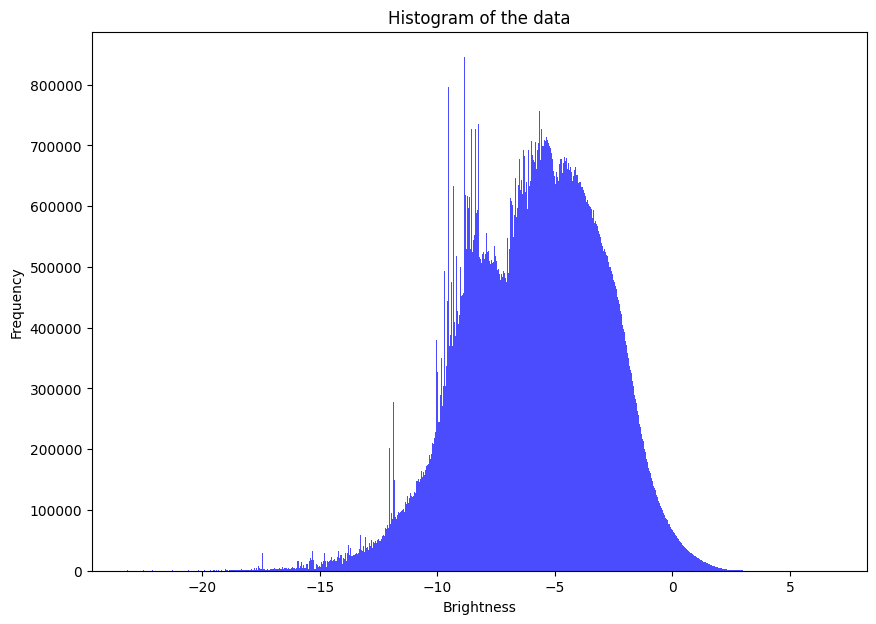

In [44]:
def plotHistogram(data):
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.hist(data.flatten(), bins=1000, color='blue', alpha=0.7)    
    ax.set_title('Histogram of the data')
    ax.set_xlabel('Brightness')
    ax.set_ylabel('Frequency')
    print (f'Nbins: {len(ax.patches)}')


plotHistogram(imag_log)
# auto(1945) : 45 sec
# 1000 : 45 sec
# 100 : 45 sec


In [46]:
def get_H(data):
    std = np.std(data)
    N = data.shape[0] * data.shape[1]
    H = 1.06 * std * N ** (-1/5)
    return H
print(get_H(imag_log))

0.052381211156031754


In [34]:
def Epinechkov_kernel(x, y, sigma=1):
    """
    Compute the Epinechnikov kernel for a pair of points x and y
    """
    # Compute the distance between the points
    d = np.sqrt((x[0] - y[0])**2 + (x[1] - y[1])**2)
    # Compute the kernel
    if d < sigma:
        return 3/4 * (1 - d**2 / sigma**2)
    else:
        return 0

In [ ]:
def Gaussian_kernel(x, y, sigma=1):
    """
    Compute the Gaussian kernel for a pair of points x and y
    """
    # Compute the distance between the points
    d = np.sqrt((x[0] - y[0])**2 + (x[1] - y[1])**2)
    # Compute the kernel
    return np.exp(-d**2 / (2 * sigma**2))

In [15]:
asdasdasd

NameError: name 'asdasdasd' is not defined

In [ ]:

# Open the raster file
with rasterio.open('World_Atlas_2015.tif') as src:
    # Get the affine transformation matrix
    transform = src.transform
    
    # The pixel resolution (size) in geographic units
    lon_res = transform.a  # Longitude resolution (degrees per pixel)
    lat_res = abs(transform.e)  # Latitude resolution (degrees per pixel), absolute value
    
    print(f"Longitude resolution: {lon_res} degrees per pixel")
    print(f"Latitude resolution: {lat_res} degrees per pixel")


Longitude resolution: 0.008333330000000002 degrees per pixel
Latitude resolution: 0.008333330000000002 degrees per pixel


In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming imag_log and geographic bounds (lon_min, lon_max, lat_min, lat_max) are defined
# # Define your sampling step for both latitude and longitude to reduce data size
# step_lat = 100  # Adjust these steps based on the resolution you desire
# step_lon = 100

# # Generate latitude and longitude arrays for the sampled points
# lats = np.linspace(lat_min, lat_max, imag_log.shape[0])[::step_lat]
# lons = np.linspace(lon_min, lon_max, imag_log.shape[1])[::step_lon]

# # Create meshgrid for longitude and latitude
# lon_grid, lat_grid = np.meshgrid(lons, lats)

# # Sample imag_log accordingly
# sampled_values = imag_log[::step_lat, ::step_lon]

# # Flatten arrays for plotting
# lon_flat = lon_grid.flatten()
# lat_flat = lat_grid.flatten()
# values_flat = sampled_values.flatten()

# # Convert longitude and latitude to radians for the Aitoff projection
# lon_rad = np.radians(lon_flat)
# lat_rad = np.radians(lat_flat)

# # Plotting
# plt.figure(figsize=(10, 5))
# plt.subplot(111, projection='aitoff')
# plt.imshow(imag_log, extent=[lon_min, lon_max, lat_min, lat_max], origin='upper')
# plt.set_xlabel('Longitude')
# plt.set_ylabel('Latitude')
# plt.set_title('Artificial Sky Brightness')
# plt.colorbar(cax, ax=ax, label='Log Brightness')


# plt.show()


In [ ]:
# Ensure imag is prepared as before, focusing on the subset of interest
# This assumes 'imag' has been defined as shown previously
# If imag is not defined here, ensure it is computed before this code

# Log transformation and masking of zeros to avoid log(0)
imag_log = np.log(imag[0:y_pixels_max, 0:x_pixels_max])
imag_log = np.ma.masked_invalid(imag_log)  # Mask invalid values

plt.figure(figsize=(10, 5))
plt.subplot(111, projection='aitoff')
plt.title("Aitoff Projection of Artificial Sky Brightness")
plt.grid(True)

# Scatter plot on Aitoff projection, coloring by log brightness values
# Mask invalid values to avoid plotting errors
masked_values = np.ma.masked_invalid(values_flat)
plt.scatter(lon_rad, lat_rad, c=masked_values, cmap='viridis', alpha=0.5, s = 2)

plt.colorbar(label='Log Brightness')
plt.show()


cax = ax.imshow(imag_log, extent=[lon_min, lon_max, lat_min, lat_max], origin='upper')
plt.scatter(imag_log)

fig.colorbar(cax, ax=ax, label='Log Brightness')

plt.show()


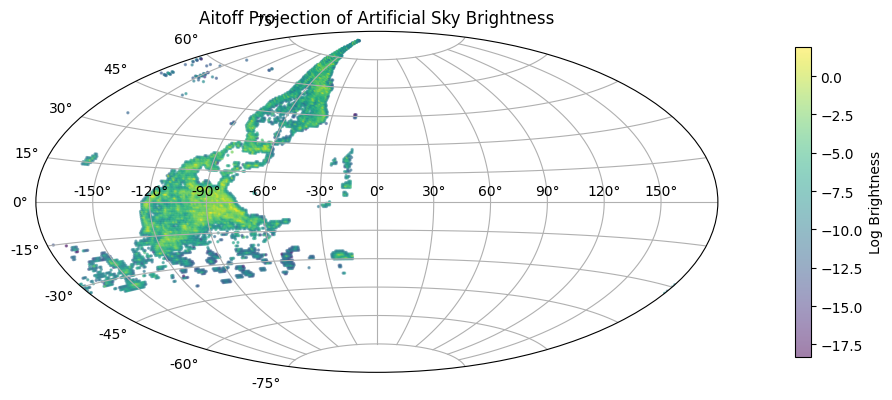

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming imag_log and geographic bounds (lon_min, lon_max, lat_min, lat_max) are defined
# And assuming imag_log, lat_min, lat_max, lon_min, lon_max are already correctly defined

# Define your sampling step for both latitude and longitude to reduce data size
step_lat = 100  # Adjust these steps based on the resolution you desire
step_lon = 100

# Generate latitude and longitude arrays for the sampled points
lats = np.linspace(lat_min, lat_max, imag_log.shape[0])[::step_lat]
lons = np.linspace(lon_min, lon_max, imag_log.shape[1])[::step_lon]

# Create meshgrid for longitude and latitude
lon_grid, lat_grid = np.meshgrid(lons, lats)

# Sample imag_log accordingly
sampled_values = imag_log[::step_lat, ::step_lon]

# Flatten arrays for plotting
lon_flat = lon_grid.flatten()
lat_flat = lat_grid.flatten()
values_flat = sampled_values.flatten()

# Convert longitude and latitude to radians for the Aitoff projection
lon_rad = np.radians(lon_flat)
lat_rad = np.radians(lat_flat)

# Adjust longitude for Aitoff projection: convert from [0, 2π] to [-π, π]
lon_rad_adjusted = np.mod(lon_rad + np.pi, 2 * np.pi) - np.pi

# Plotting
plt.figure(figsize=(10, 5))
ax = plt.subplot(111, projection='aitoff')
plt.title("Aitoff Projection of Artificial Sky Brightness")
plt.grid(True)

# Scatter plot on Aitoff projection, coloring by log brightness values
# Mask invalid values to avoid plotting errors
masked_values = np.ma.masked_invalid(values_flat)
sc = ax.scatter(lon_rad_adjusted, lat_rad, c=masked_values, cmap='viridis', alpha=0.5, s=2)

# Adding a colorbar
cbar = plt.colorbar(sc, orientation='vertical', fraction=0.02, pad=0.1)
cbar.set_label('Log Brightness')

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming imag_log and geographic bounds (lon_min, lon_max, lat_min, lat_max) are defined
# Define your sampling step for both latitude and longitude to reduce data size
step_lat = 100  # Adjust these steps based on the resolution you desire
step_lon = 100

# Generate latitude and longitude arrays for the sampled points
lats = np.linspace(lat_min, lat_max, imag_log.shape[0])[::step_lat]
lons = np.linspace(lon_min, lon_max, imag_log.shape[1])[::step_lon]

# Create meshgrid for longitude and latitude
lon_grid, lat_grid = np.meshgrid(lons, lats)

# Sample imag_log accordingly
sampled_values = imag_log[::step_lat, ::step_lon]

# Flatten arrays for plotting
lon_flat = lon_grid.flatten()
lat_flat = lat_grid.flatten()
values_flat = sampled_values.flatten()

# Convert longitude and latitude to radians for the Aitoff projection
lon_rad = np.radians(lon_flat)
lat_rad = np.radians(lat_flat)

# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(111, projection='aitoff')
plt.title("Aitoff Projection of Artificial Sky Brightness")
plt.grid(True)

# Scatter plot on Aitoff projection, coloring by log brightness values
# Mask invalid values to avoid plotting errors
masked_values = np.ma.masked_invalid(values_flat)
plt.scatter(lon_rad, lat_rad, c=masked_values, cmap='viridis', alpha=0.5, s = 2)

plt.colorbar(label='Log Brightness')
plt.show()


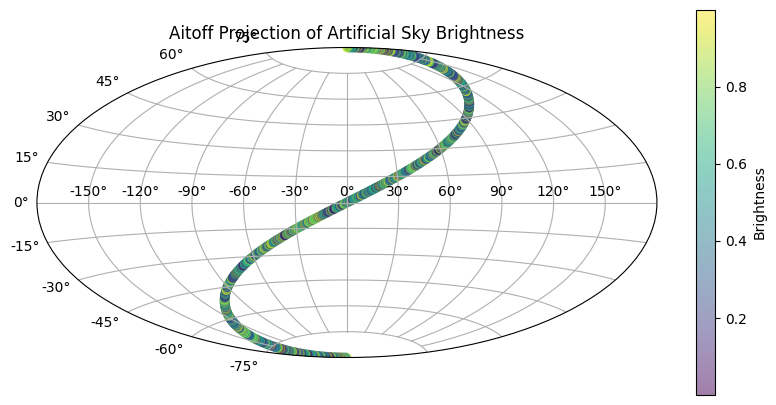

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have latitude and longitude arrays for your data points
# and a corresponding brightness array for those points
# For demonstration, we'll create some dummy data
num_points = 1000
lons = np.linspace(-180, 180, num_points)
lats = np.linspace(-90, 90, num_points)
brightness = np.random.rand(num_points)  # Dummy brightness values

# Convert longitude and latitude to radians for the plot
lons_rad = np.radians(lons)
lats_rad = np.radians(lats)

# Adjust longitude for Aitoff projection: convert from [0, 2π] to [-π, π]
lons_rad_plot = np.mod(lons_rad + np.pi, 2 * np.pi) - np.pi

# Convert latitude for Aitoff projection
# Latitude ranges from [-π/2, π/2] already, so no change needed for co-latitude

# Prepare the brightness values for plotting (e.g., scaling, normalization)
# Here we'll simply use the brightness as-is, assuming it's suitable for direct plotting
brightness_plot = brightness  # Placeholder for any actual preparation

# Set up the plot with Aitoff projection
plt.figure(figsize=(10, 5))
plt.subplot(111, projection='aitoff')
plt.title("Aitoff Projection of Artificial Sky Brightness")
plt.grid(True)

# Scatter plot on Aitoff projection
# Using brightness for color coding
plt.scatter(lons_rad_plot, lats_rad, c=brightness_plot, cmap='viridis', alpha=0.5)

# Colorbar
plt.colorbar(label='Brightness')

# Show plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from torchvision.transforms import ToTensor

# Open the TIFF file
with rasterio.open('World_Atlas_2015.tif') as image:
    # Read the image data
    image_array = image.read(1)  # Reading just one band
    
    # Convert to a PyTorch tensor and then back to numpy for plotting
    torch_image = ToTensor()(image_array).numpy()
    
    # Get the affine transformation
    transform = image.transform
    
    # Convert the pixel coordinates of the corners to geographic coordinates
    # Bottom-left corner (min x, min y)
    min_x, min_y = transform * (0, image.height)
    # Top-right corner (max x, max y)
    max_x, max_y = transform * (image.width, 0)

# Use logarithmic scaling to enhance visualization
log_image = np.log(torch_image)

# Plotting
plt.figure(figsize=(10, 8))
# Define the extent using the geographic coordinates
plt.imshow(log_image, extent=[min_x, max_x, min_y, max_y], cmap='viridis')
plt.colorbar(label='Log-scaled Brightness')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Artificial Night Sky Brightness')
plt.show()


array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
import rasterio

def get_raster_info(file_path):
    with rasterio.open(file_path) as src:
        width = src.width
        height = src.height
        bands = src.count
        crs = src.crs
        transform = src.transform
        dtype = src.dtypes[0]
        
    return {
        "width": width,
        "height": height,
        "bands": bands,
        "coordinate_reference_system": crs,
        "transform": transform,
        "data_type": dtype
    }

# Replace 'your_file.tif' with the path to your TIFF file
raster_info = get_raster_info(file_name)
print(raster_info)


{'width': 43200, 'height': 17406, 'bands': 1, 'coordinate_reference_system': CRS.from_epsg(4326), 'transform': Affine(0.008333330000000002, 0.0, -180.00000000000003,
       0.0, -0.008333330000000002, 85.0541668645001), 'data_type': 'float32'}
